# Lab/ Audio/ Music Structure Discovery (MSD) / Boundaries Detection 

- Author: geoffroy.peeters@telecom-paris.fr
- Date: 2022/01/31
- Version: 1.0

## Introduction

The goal of this goal is to create a system to perform Music Structure Discovery (MSD), i.e. segmenting a music track into its various verses, chorus, briges, ...

MSD systems usually perform two tasks
- (a) Estimating the **segments** of the music track
- (b) **Labeling** each estimated segments, i.e. deciding which segments is a repetition of another one

We will focus on the segmentation task for this lab.

To estimate the segments you will perform the following steps
- (1) Extracting audio features for the music track; you will extract here both Chroma and MFCC
- (2) Compute the corresponding Self-Similarity-Matrix (SSM) using a cosine-distance: one SSM for the Chroma; one SSM for the MFCC
- (3) Combine the two SSMs 
- (4) Compute the novelty-score proposed by Jonathan Foote, by convolving the combined SSMs with a checker-board kernel
- (5) Detect the local peaks of the novelty-score by applying a peak-picking algorithm
- (6) Measure the performances of the developped algorithm for one track of the SALAMA dataset.

For (1) you will use the **librosa** package, which is (currently) the most used python package for music and audio analysis. It has been developped by Columbia University and New-York University.
https://librosa.org/doc/latest/index.html.

For (6) you will use the **mir_eval** package which is (currently) the most used python package to evaluate the performances of Music Information Retrieval (MIR) algorithms. https://craffel.github.io/mir_eval/

## Your task:

In the following the main code (global architecture) is provided as well as the results you have to find.
Your task is to fill in the missing parts in the code; i.e. the parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```).

# Import packages

In [457]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [458]:
import numpy as np

from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.signal import convolve2d

import matplotlib.pyplot as plt
from matplotlib import cm

import librosa
import mir_eval

import tools_structure

do_student = True

audio_file = './audio.mp3'
annot_file = './textfile1_lowercase.txt'

In [459]:
audio_v, sr = librosa.load(audio_file, sr = None)

C:\Users\_Minh_\AppData\Local\Temp/ipykernel_11172/835500049.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_v, sr = librosa.load(audio_file, sr = None)


# Extract audio features

From the audio file we will first compute the audio features.

As proposed in [Peeters, ISMIR, 2017], the music structure can either comes 
- from variations of the harmonic (melody, chords) content or 
- from variations of the timbre (instrumentation) content. 

In order to take both into account, we will therefore extract both Chroma and MFCC features.

You will do so by using the **librosa** package. 
You will use the default values for the parametrization of the Chroma and MFCC; but will use the given hop_length, and will use the CQT algorithm for the Chroma computation.

In [460]:
def F_extract_features(audio_file, hop_length):
    """
    description:
        Compute the Chroma and MFCC features of the given audio_file
    inputs:
        - audio_file: full-path to the audio file
        - hop_length: hop_length to be used for the analysis in samples
    outputs:
        - chroma_m (nb_dim, nb_frame) numpy matrix containing the Chroma over frames
        - mfcc_m (nb_dim, nb_frame) numpy matrix containing the MFCC over frames
        - time_sec_v (nb_frame) numpy vector containing the position of the analysis frames in second
    """
    if do_student:
        #audio_v, sr = librosa.load(audio_file, sr = None)
        audio_v, sr = librosa.load(audio_file)
        print("Sampling rate: ", sr)
        print("Audio length in vector:", audio_v.shape)
        
        chroma_m = librosa.feature.chroma_cqt(y = audio_v, sr=sr, hop_length = hop_length)
        mfcc_m = librosa.feature.mfcc(y = audio_v, sr=sr, hop_length=hop_length)
        time_sec_v = np.arange(0, audio_v.shape[0], hop_length)/sr
        #time_sec_v = np.arange(chroma_m.shape[1])*hop_length/sr
    
    return chroma_m, mfcc_m, time_sec_v

### Test

You should obtain the following values
```
(12, 6767)
(20, 6767)
(6767,)
```

In [461]:
chroma_m, mfcc_m, time_sec_v = F_extract_features(audio_file, hop_length=1024)
print(chroma_m.shape)
print(mfcc_m.shape)
print(time_sec_v.shape)

C:\Users\_Minh_\AppData\Local\Temp/ipykernel_11172/3751674364.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_v, sr = librosa.load(audio_file)


Sampling rate:  22050
Audio length in vector: (6928704,)
(12, 6767)
(20, 6767)
(6767,)


## Reducing the number of data

To represent a whole music track of 4 minutes, we need over 6767 frames.
The corresponding Self-Similarity-Matrix (SSM) would have an enormous size (6767*6767). 

We therefore reduce the amount of data.
We do this by performing a statistical-aggregation (by mean and std) of the feature behavior over time. 
We perform a sliding analysis (with a specific window duration and hop-size) over each dimension of the MFCC and Chroma features.

```
(24, 1352)
(40, 1352)
(1352,)
```

In [462]:
tmp, chroma_m = tools_structure.F_reduce_time(time_sec_v, chroma_m)
time_sec_v, mfcc_m = tools_structure.F_reduce_time(time_sec_v, mfcc_m)
print(chroma_m.shape)
print(mfcc_m.shape)
print(time_sec_v.shape)

(24, 1352)
(40, 1352)
(1352,)


# Compute Self-Similarity Matrix

For each of the features (MFCC or Chroma) you will compute the corresponding Self-Similarity Matrix (SSM) using the cosine-distance.

In [463]:
def F_compute_SSM(features_m):
    """
    descriptions:
        compute Self-Similarity-Matrix (SSM) from audio feature matrix using cosine-distance.
    inputs:
        - features_m (nb_dim, nb_frame)
    outputs:
        - SSM_m (nb_frame, nb_frame)
    """
    
    if do_student:
        nb_frame = features_m.shape[1]
        u_dot_v = np.dot(features_m.T, features_m)
        u_norm = np.linalg.norm(features_m, axis = 0)
        v_norm = u_norm
        u_norm_mesh, v_norm_mesh = np.meshgrid(u_norm, v_norm)
        norm_product = u_norm_mesh*v_norm_mesh
        SSM_m = u_dot_v/norm_product
    return SSM_m

In [464]:
SSMchroma_m = F_compute_SSM(chroma_m)
SSMmfcc_m = F_compute_SSM(mfcc_m)

We apply some magical processing (as proposed in [Peeters, ISMIR, 2007]) to make the SSM matrices more beautifull.

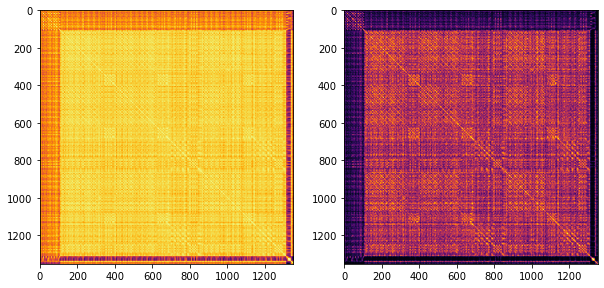

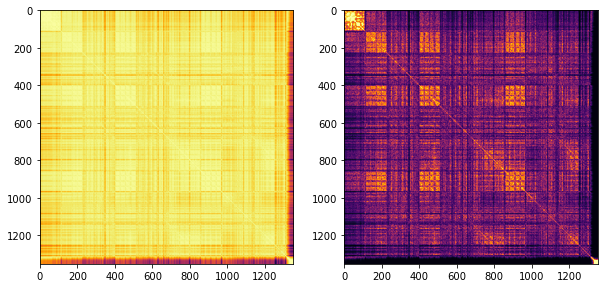

In [465]:
SSMchroma_m = tools_structure.F_stretch_ssm(SSMchroma_m)
SSMmfcc_m = tools_structure.F_stretch_ssm(SSMmfcc_m)

We finally combine both the MFCC SSM matrix and the Chroma SSM matrix. You can try various values of the alpha parameters to highlight more harmonic structure (alpha=1) or timbre structure (alpha=0).

In [466]:
alpha = 0.5
SSM_m = alpha*SSMchroma_m + (1-alpha)*SSMmfcc_m

### Test 

You should obtain the following figure for the SSM.
<img src=./lab_structure_ssm-combined.png width=600px>

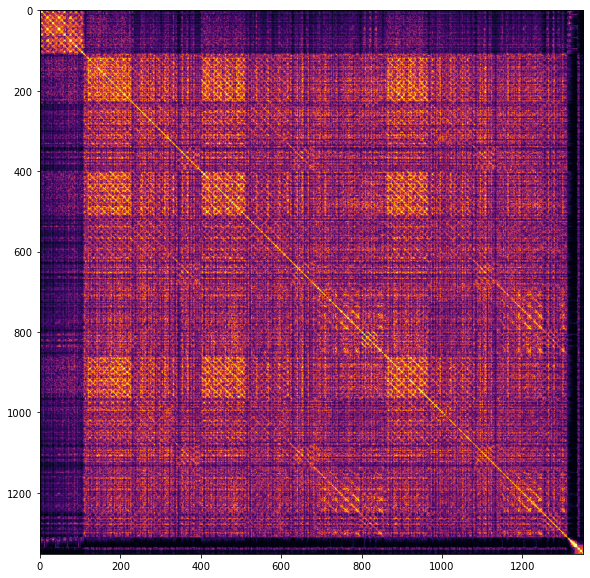

In [467]:
plt.figure(figsize=(10,10))
plt.imshow(SSM_m, aspect='equal', cmap=cm.inferno);

# Segmentation: checkerboard-kernel, novelty score

We now perform the segmentation of the music track by convolving its SSM with a checker-board kernel as proposed by [Foote, ICME, 2000].


We first created the checkerboard kernel ``C_m``. 
It is defined by 
$$C(m,n) = sign(m) \cdot sign(n) \cdot e^{-\frac{m^2+n^2}{2\sigma^2}}$$
for $m, n \in \{-L,\ldots, L-1\}$.
The size of the kernel is $(2L, 2L$.
$\sigma$ is the standard-deviation of the Gaussian window used to smooth the borders of checkerboard kernel.

In [468]:
def F_checkerboard_kernel(L=10, sigma=5, do_affiche=True):

    if do_student:
        m_v = np.arange(-L, L+1)
        m_v = np.delete(m_v, np.where(m_v==0))
        n_v = n_v = m_v
        x, y = np.meshgrid(m_v, n_v)
        C_m = (np.sign(x)*np.sign(y)*np.exp(-(x**2+y**2)/(2*sigma**2)))
        
    if do_affiche:
        plt.figure(figsize=(10,10))
        X, Y = np.meshgrid(m_v, n_v)
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, C_m, cmap=cm.inferno)
        ax.set_xlabel('m')
        ax.set_ylabel('n')
        ax.view_init(50, -20)
    return C_m

### Test 

You should obtain the following figure for the checkerboard kernel.
<img src=./lab_structure_kernel.png width=600px>

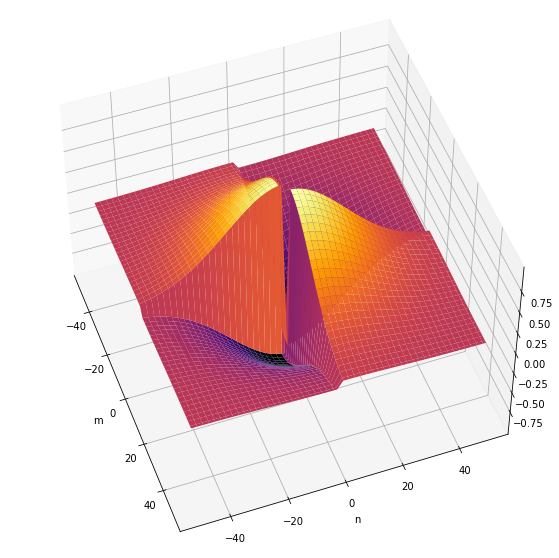

In [469]:
C_m = F_checkerboard_kernel(L=50, sigma=20, do_affiche=True);

We now convolve our combined SSM matrix ``SSM_m`` with our checkerboard kernel ``C_m``. You can use ``scipy`` for this.

In [470]:
if do_student:
    filtered_SSM_m = convolve2d(SSM_m, C_m, mode ='same')

The novelty curve ``novelty_v`` are the values of the convolved matrix ``filtered_SSM_m`` along its main diagonal.

In [471]:
if do_student:
    novelty_v = filtered_SSM_m.diagonal()

### Test 

You should obtain the following figures for the resulting convolution and novelty curve.
<img src=./lab_structure_convolved.png width=600px>

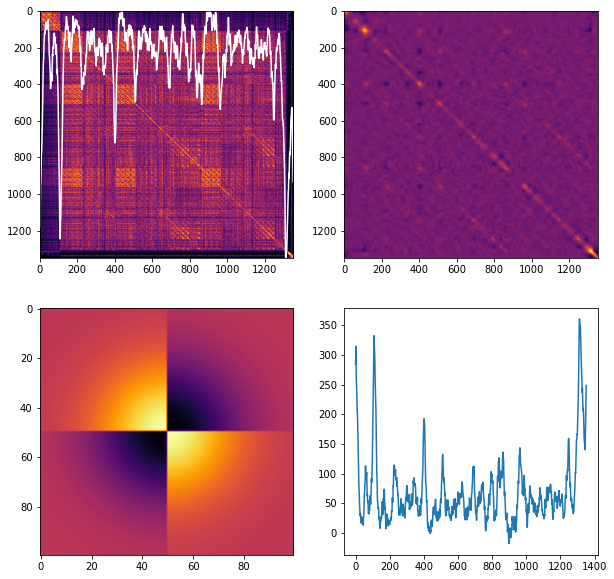

In [472]:
plt.figure(figsize=(10,10))

nb_frame = len(novelty_v)

plt.subplot(2,2,1)
plt.imshow(SSM_m, aspect='auto', cmap=cm.inferno);
plt.plot(novelty_v/np.max(novelty_v)*nb_frame, 'w');
plt.xlim([0, nb_frame]); plt.ylim([nb_frame, 0])

plt.subplot(2,2,2)
plt.imshow(filtered_SSM_m, aspect='auto', cmap=cm.inferno);

plt.subplot(2,2,3)
plt.imshow(C_m, aspect='auto', cmap=cm.inferno);

plt.subplot(2,2,4)
plt.plot(novelty_v);

## Detect the peaks of the novelty curve

Peaks in the novelty curve indicates large changes between the part on the left of the peak and the part of the right of the peak; hence they indicates large structural changes in the music track.

To detect the peaks in the novelty function we will use a method inspired by the ones of (but improved) [MacCallumn, ICASSP, 2019].

We denote by $\eta(\nu)$ the novelty function over time $\nu$.

A peak is defined by 

(1) a value $\mu$ which is larger than its **local average** value by a factor $\tau$ (the threshold). This **local average** value is compute over a window centered on $\nu$ and which extends over $[\nu-T, \nu+T]$.

$$\frac{\eta(\nu)}{\frac{1}{2T+1}\sum_{t=\nu-T}^{\nu+T}\eta(t)} > \tau$$

(2) In order to prevent detecting several neighboring peaks, we also requires that the specific $\mu$ is at the position of the local maximum over $[\nu-T, \nu+T]$, i.e. $$\nu = \arg\max_{t \in [\nu-T, \nu+T]} \eta(t)$$.

In [473]:
def F_peak_picking(novelty_v, T=30, tau=1.3):
    """
    description:
        - detect the peaks (performs peak-picking) of the novelty curve as described in the text above
    inputs:
        - novelty (nb_frame): numpy array containing the novelty function
        - T: defines the size of the interval [nu-T, nu+T] over which the mean value is computed
        - tau: defines the threshold
    outputs:
        - peaks_l: provides the list of boundary **positions** 
        - mean_v (nb_frame): numpy array containing  the local running average of novelty_v using T 
    """
    length = novelty_v.shape[0]
    peaks_l = []
    mean_v = np.zeros(length)
    if do_student:
        
        for i in range(T, length-T-1):
            mu = novelty_v[i]
            #window = novelty_v[left_boundary:right_boundary]
            window = novelty_v[i-T:i+T+1]
            mean_window = np.mean(window)
            mean_v[i]=mean_window
            if mu/mean_window > tau and mu == np.max(window):
                peaks_l.append(i)
    
    #mean_v = np.array(mean_v)
    return peaks_l, mean_v

In [474]:
peaks_l, mean_v = F_peak_picking(novelty_v)

# --- For proper comparison with the ground-truth annotation, we need to add a boundaries 
# --- at the beginning and ending of the music track
peaks_l.append(0)
peaks_l.append(len(novelty_v)-1)
estimated_boundaries_l = time_sec_v[ sorted(peaks_l) ]

### Test

You should obtain the following boundaries

```
[2.08979592e-01 1.36765533e+01 2.52865306e+01 3.92185034e+01
 5.24538776e+01 6.96366440e+01 7.96212245e+01 9.30887982e+01
 1.08878367e+02 1.18630748e+02 1.44869297e+02 1.60194467e+02
 1.84343220e+02 1.95256599e+02 2.23817143e+02 2.37284717e+02
 2.50984490e+02 2.65613061e+02 2.76990839e+02 2.90226213e+02
 3.04622585e+02 3.13910567e+02]
```

In [475]:
print(estimated_boundaries_l)

[2.08979592e-01 1.36765533e+01 2.52865306e+01 3.92185034e+01
 5.22216780e+01 6.98688435e+01 7.96212245e+01 9.30887982e+01
 1.18630748e+02 1.44869297e+02 1.61123265e+02 1.73197642e+02
 1.84575420e+02 2.00597188e+02 2.23817143e+02 2.37284717e+02
 2.51216689e+02 2.65380862e+02 2.76990839e+02 2.90226213e+02
 3.04854785e+02 3.13910567e+02]


# Estimate the quality of the detected segment boundaries

We now measure the performance of our system.

For this, we will compare our estimated boundaries to the ground-truth segment boundaries on a music track from the SALAMI dataset.

In [476]:
# --- Loading the ground-truth annotations
annot_l = tools_structure.F_get_structure_annot(annot_file)
annotated_boundaries_l = np.asarray([a[0] for a in annot_l])

### Test 

You should obtains segmentations similar to the following figure.
<img src=./lab_structure_segments.png width=600px>

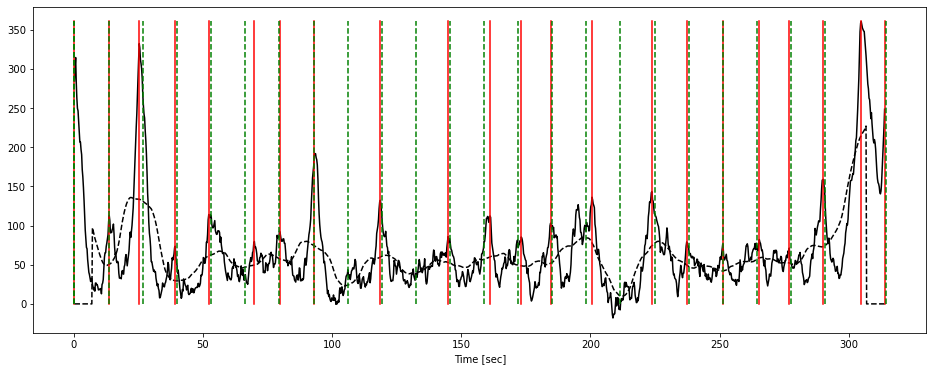

In [477]:
plt.figure(figsize=(16,6))
plt.plot(time_sec_v, novelty_v, 'k');
plt.plot(time_sec_v, mean_v, 'k--');
for e in estimated_boundaries_l:
    plt.plot([e, e], [0, np.max(novelty_v)], 'r');
for a in annotated_boundaries_l:
    plt.plot([a, a], [0, np.max(novelty_v)], 'g--');
plt.xlabel('Time [sec]');

# Measuring the performances

To quantify the performances of our system we will compare the estimation and the ground-truth annotations using the Precision, Recall and F-Measure.
We will do so by defining a tolerance window (around the annotations) of 0.5 second and 3 second. 

You will will use the **mir_eval** python package for this. This package provides the performance measures for all MIR tasks (including segment boundaries detection).

```
import mir_eval
mir_eval.***
```

You will find the documentation here:
https://craffel.github.io/mir_eval/#mir_eval.segment.detection

You can optimize the parameters of the peak-picking function for the two cases.

In [478]:
# --- To be able to use mir_eval, we should first convert the segment boundaries to segments start and stop
annotated_segment_m = tools_structure.F_boundaries_to_segments(annotated_boundaries_l)
estimated_segment_m = tools_structure.F_boundaries_to_segments(estimated_boundaries_l)

if do_student:
    Precision05, Recall05, Fmeasure05 = mir_eval.segment.detection(annotated_segment_m, estimated_segment_m, window=0.5)
    Precision3, Recall3, Fmeasure3 = mir_eval.segment.detection(annotated_segment_m, estimated_segment_m, window=3.0)

### Test

You should have the following values
```
at 0.5 second: 	 Precision 0.2727272727272727, Recall 0.24, F-Measure0.2553191489361702
at 3 second: 	 Precision 0.8636363636363636, Recall 0.76, F-Measure0.8085106382978724
```

In [479]:
print('at 0.5 second: \t Precision {}, Recall {}, F-Measure{}'.format(Precision05, Recall05, Fmeasure05))
print('at 3 second: \t Precision {}, Recall {}, F-Measure{}'.format(Precision3, Recall3, Fmeasure3))

at 0.5 second: 	 Precision 0.2727272727272727, Recall 0.24, F-Measure0.2553191489361702
at 3 second: 	 Precision 0.9090909090909091, Recall 0.8, F-Measure0.8510638297872342
